Reshape data function

In [1]:
from numpy import array
# split a univariate sequence into samples
def split_sequence(sequence, n_steps_in, n_steps_out):
	X, y = list(), list()
	for i in range(len(sequence)):
		# find the end of this pattern
		end_ix = i + n_steps_in
		out_end_ix = end_ix + n_steps_out
		# check if we are beyond the sequence
		if out_end_ix > len(sequence):
			break
		# gather input and output parts of the pattern
		seq_x, seq_y = sequence[i:end_ix], sequence[end_ix:out_end_ix]
		X.append(seq_x)
		y.append(seq_y)
	return array(X), array(y)


raw_seq = [10, 20, 30, 40, 50, 60, 70, 80, 90]
# choose a number of time steps
n_steps_in, n_steps_out = 3, 2
# split into samples
X, y = split_sequence(raw_seq, n_steps_in, n_steps_out)
# summarize the data
for i in range(len(X)):
	print(X[i], y[i])

[10 20 30] [40 50]
[20 30 40] [50 60]
[30 40 50] [60 70]
[40 50 60] [70 80]
[50 60 70] [80 90]


Reading input data from csv file

      Unnamed: 0                 TIMESTAMP    IN_BYTES    OUT_BYTES  IN_PKTS  \
0              0  2019-09-03T00:00:00.000Z    7.155094    14.155175   24.485   
1              1  2019-09-03T00:05:00.000Z   13.348389    32.448919   32.219   
2              2  2019-09-03T00:10:00.000Z   10.753576   143.369509   57.037   
3              3  2019-09-03T00:15:00.000Z    9.567548   108.402278   51.635   
4              4  2019-09-03T00:20:00.000Z    9.484544   143.215871   51.592   
...          ...                       ...         ...          ...      ...   
1878        1878  2019-09-10T03:55:00.000Z  256.369680  1126.312145  573.293   
1879        1879  2019-09-10T04:00:00.000Z  166.672691   618.799843  404.410   
1880        1880  2019-09-10T04:05:00.000Z  321.680011  1241.244513  706.464   
1881        1881  2019-09-10T04:10:00.000Z  186.199376   813.486152  472.318   
1882        1882  2019-09-10T04:15:00.000Z   58.363507   160.651407  110.640   

      OUT_PKTS  COUNTS  
0       22.724

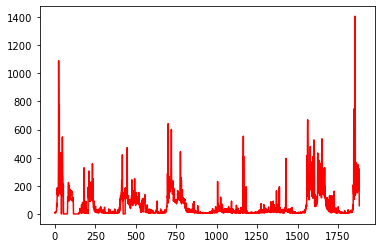

In [4]:
import pandas as pd
import matplotlib.pyplot as plt

data = pd.read_csv('./../data/sensor-cmc-corp.csv')
data['IN_BYTES'] = data['IN_BYTES']/10**6
data['OUT_BYTES'] = data['OUT_BYTES']/10**6
data['IN_PKTS'] = data['IN_PKTS']/10**3
data['OUT_PKTS'] = data['OUT_PKTS']/10**3

print(data)
plt.plot(data['IN_BYTES'], color='red')
# plt.plot(data['IN_PKTS'], color='blue')
# plt.plot(data['OUT_BYTES'], color='green')
# plt.plot(data['OUT_PKTS'], color='yellow')
# plt.plot(data['COUNTS'], color='black')
plt.show()

data['IN_BYTES']

In [19]:
data_seq = data['IN_BYTES']
n_step_in = 144
n_step_out = 12
X, y = split_sequence(data_seq, n_step_in, n_step_out)
print(X.shape)
print(X)

(1729, 144)
[[  8.11094    5.944078  18.608086 ...  15.373452  12.179414  13.058352]
 [  5.944078  18.608086  16.082056 ...  12.179414  13.058352  31.088832]
 [ 18.608086  16.082056  27.655063 ...  13.058352  31.088832  15.28102 ]
 ...
 [ 12.631203  25.988345  19.554531 ... 478.765407 202.124776 178.088696]
 [ 25.988345  19.554531  11.624128 ... 202.124776 178.088696 299.876191]
 [ 19.554531  11.624128  13.769077 ... 178.088696 299.876191 184.755276]]


In [20]:
# from numpy import reshape

n_feature = 1
X = X.reshape(X.shape[0], X.shape[1], n_feature)
print(X.shape)

(1729, 144, 1)


In [21]:
from keras.models import Sequential
from keras.layers import LSTM
from keras.layers import Dense

model = Sequential()
model.add(LSTM(256, activation='tanh', return_sequences=True, input_shape=(n_step_in, n_feature)))
model.add(LSTM(512, activation='sigmoid', return_sequences=True))
model.add(LSTM(1024, activation='sigmoid', return_sequences=True))
model.add(LSTM(512, activation='sigmoid', return_sequences=True))
model.add(LSTM(256, activation='tanh'))
model.add(Dense(n_step_out))
model.compile(optimizer='adam', loss='mse')
model.summary()

Model: "sequential_7"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_19 (LSTM)               (None, 144, 256)          264192    
_________________________________________________________________
lstm_20 (LSTM)               (None, 144, 512)          1574912   
_________________________________________________________________
lstm_21 (LSTM)               (None, 144, 1024)         6295552   
_________________________________________________________________
lstm_22 (LSTM)               (None, 144, 512)          3147776   
_________________________________________________________________
lstm_23 (LSTM)               (None, 256)               787456    
_________________________________________________________________
dense_7 (Dense)              (None, 12)                3084      
Total params: 12,072,972
Trainable params: 12,072,972
Non-trainable params: 0
__________________________________________

In [22]:
model.fit(X, y, epochs=200)

Epoch 1/200
1729/1729 [==============================] - 68s 39ms/step - loss: 8728.6712
Epoch 2/200
1729/1729 [==============================] - 63s 36ms/step - loss: 7915.5816
Epoch 3/200
1729/1729 [==============================] - 67s 39ms/step - loss: 7554.6876
Epoch 4/200
1729/1729 [==============================] - 65s 38ms/step - loss: 7357.7316
Epoch 5/200
1729/1729 [==============================] - 67s 39ms/step - loss: 7244.2160
Epoch 6/200
1729/1729 [==============================] - 69s 40ms/step - loss: 7193.3387
Epoch 7/200
1729/1729 [==============================] - 71s 41ms/step - loss: 7170.7395
Epoch 8/200
1729/1729 [==============================] - 72s 42ms/step - loss: 7156.8729
Epoch 9/200
1729/1729 [==============================] - 66s 38ms/step - loss: 7149.2433
Epoch 10/200
  96/1729 [>.............................] - ETA: 57s - loss: 7635.5211

KeyboardInterrupt: 